<a href="https://colab.research.google.com/github/sunandhini96/ERA_S9/blob/main/ERA_S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Write a new network that
has the architecture to C1C2C3C40 (No MaxPooling, but 3 convolutions, where the last one has a stride of 2 instead) (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, then 200pts extra!)
total RF must be more than 44

one of the layers must use Depthwise Separable Convolution

one of the layers must use Dilated Convolution

use GAP (compulsory):- add FC after GAP to target #of classes (optional)

use albumentation library and apply:
horizontal flip
shiftScaleRotate
coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)

achieve 85% accuracy, as many epochs as you want. Total Params to be less than 200k.

In [1]:
!git clone https://github.com/katipallyvig8899/ERA_9.git

Cloning into 'ERA_9'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (4/4), 274.48 KiB | 1.15 MiB/s, done.


In [2]:
cd /content/ERA_9

/content/ERA_9


In [3]:
pwd

'/content/ERA_9'

In [4]:
!python model.py

## importing model

In [5]:
from model import *

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## defining train and test transformations

In [7]:

mean=(0.4914, 0.4822, 0.4465)
std=(0.2470, 0.2435, 0.2616)
def train_transform_function(mean,std):
    train_transform = A.Compose([A.Normalize(mean,std,always_apply=True),
                                 #A.PadIfNeeded(min_height=40,min_width=40,always_apply=True),
                                 #A.RandomCrop(height=32,width=32,always_apply=True),
                                 A.HorizontalFlip(),
                                 A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05,rotate_limit=15,p=0.5),
                                 A.CoarseDropout(max_holes=1,max_height=16,max_width=16, min_holes=1, min_height=16,min_width=16, fill_value=mean, mask_fill_value = None),
                                 ToTensorV2()

                                       ])
    return lambda img:train_transform(image=np.array(img))["image"]

In [8]:


# Test Phase transformations
def test_transform_function(mean,std):
      test_transform = A.Compose([
                                            #  transforms.Resize((28, 28)),
                                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),

                                            #transforms.ToTensor(),
                                            A.Normalize(mean,std),
                                            ToTensorV2()
                                            #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                            ])
      return lambda img:test_transform(image=np.array(img))["image"]


In [9]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform_function(mean,std))
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform_function(mean,std))

100%|██████████| 170498071/170498071 [00:13<00:00, 13046149.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Visualization

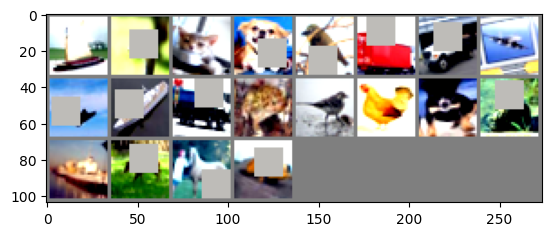

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:20]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(20)))

## Summary of the Model

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             288
            Conv2d-6           [-1, 64, 32, 32]           2,048
depthwise_separable_conv-7           [-1, 64, 32, 32]               0
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 32, 16, 16]          18,432
           Conv2d-12           [-1, 64, 16, 16]          18,432
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14        

## Training the model

In [13]:
from model import train,test

In [14]:
from torch.optim.lr_scheduler import StepLR
#from torch_lr_finder import LRFinder

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.4872100353240967 Batch_id=97 Accuracy=32.47: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 1.4971, Accuracy: 4442/10000 (44.42%)

EPOCH: 1


Loss=1.3728349208831787 Batch_id=97 Accuracy=45.34: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]



Test set: Average loss: 1.3413, Accuracy: 5103/10000 (51.03%)

EPOCH: 2


Loss=1.3310579061508179 Batch_id=97 Accuracy=51.24: 100%|██████████| 98/98 [00:16<00:00,  5.98it/s]



Test set: Average loss: 1.1828, Accuracy: 5752/10000 (57.52%)

EPOCH: 3


Loss=1.134885549545288 Batch_id=97 Accuracy=55.47: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 1.0545, Accuracy: 6232/10000 (62.32%)

EPOCH: 4


Loss=1.1428381204605103 Batch_id=97 Accuracy=58.40: 100%|██████████| 98/98 [00:17<00:00,  5.49it/s]



Test set: Average loss: 1.0038, Accuracy: 6416/10000 (64.16%)

EPOCH: 5


Loss=1.0948206186294556 Batch_id=97 Accuracy=61.15: 100%|██████████| 98/98 [00:15<00:00,  6.16it/s]



Test set: Average loss: 0.9056, Accuracy: 6828/10000 (68.28%)

EPOCH: 6


Loss=1.0929577350616455 Batch_id=97 Accuracy=63.30: 100%|██████████| 98/98 [00:16<00:00,  5.81it/s]



Test set: Average loss: 0.8464, Accuracy: 7040/10000 (70.40%)

EPOCH: 7


Loss=0.9938581585884094 Batch_id=97 Accuracy=65.26: 100%|██████████| 98/98 [00:15<00:00,  6.14it/s]



Test set: Average loss: 0.8305, Accuracy: 7075/10000 (70.75%)

EPOCH: 8


Loss=0.9315809607505798 Batch_id=97 Accuracy=66.54: 100%|██████████| 98/98 [00:17<00:00,  5.51it/s]



Test set: Average loss: 0.7908, Accuracy: 7269/10000 (72.69%)

EPOCH: 9


Loss=0.8915642499923706 Batch_id=97 Accuracy=67.56: 100%|██████████| 98/98 [00:15<00:00,  6.14it/s]



Test set: Average loss: 0.7579, Accuracy: 7367/10000 (73.67%)

EPOCH: 10


Loss=0.9338841438293457 Batch_id=97 Accuracy=68.63: 100%|██████████| 98/98 [00:16<00:00,  6.03it/s]



Test set: Average loss: 0.7113, Accuracy: 7525/10000 (75.25%)

EPOCH: 11


Loss=0.9038282036781311 Batch_id=97 Accuracy=69.84: 100%|██████████| 98/98 [00:15<00:00,  6.14it/s]



Test set: Average loss: 0.6779, Accuracy: 7638/10000 (76.38%)

EPOCH: 12


Loss=0.9037186503410339 Batch_id=97 Accuracy=70.37: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.6810, Accuracy: 7611/10000 (76.11%)

EPOCH: 13


Loss=0.8124051094055176 Batch_id=97 Accuracy=71.02: 100%|██████████| 98/98 [00:16<00:00,  6.05it/s]



Test set: Average loss: 0.6810, Accuracy: 7605/10000 (76.05%)

EPOCH: 14


Loss=0.8708014488220215 Batch_id=97 Accuracy=72.09: 100%|██████████| 98/98 [00:15<00:00,  6.14it/s]



Test set: Average loss: 0.6361, Accuracy: 7799/10000 (77.99%)

EPOCH: 15


Loss=0.7759112119674683 Batch_id=97 Accuracy=72.33: 100%|██████████| 98/98 [00:17<00:00,  5.53it/s]



Test set: Average loss: 0.6147, Accuracy: 7864/10000 (78.64%)

EPOCH: 16


Loss=0.7022073864936829 Batch_id=97 Accuracy=73.10: 100%|██████████| 98/98 [00:16<00:00,  6.02it/s]



Test set: Average loss: 0.6023, Accuracy: 7940/10000 (79.40%)

EPOCH: 17


Loss=0.9129685163497925 Batch_id=97 Accuracy=73.44: 100%|██████████| 98/98 [00:16<00:00,  6.06it/s]



Test set: Average loss: 0.6188, Accuracy: 7867/10000 (78.67%)

EPOCH: 18


Loss=0.7035414576530457 Batch_id=97 Accuracy=73.75: 100%|██████████| 98/98 [00:16<00:00,  6.07it/s]



Test set: Average loss: 0.6000, Accuracy: 7894/10000 (78.94%)

EPOCH: 19


Loss=0.6757366061210632 Batch_id=97 Accuracy=74.21: 100%|██████████| 98/98 [00:16<00:00,  5.98it/s]



Test set: Average loss: 0.6112, Accuracy: 7898/10000 (78.98%)

EPOCH: 20


Loss=0.6694346070289612 Batch_id=97 Accuracy=74.84: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]



Test set: Average loss: 0.5550, Accuracy: 8120/10000 (81.20%)

EPOCH: 21


Loss=0.8568608164787292 Batch_id=97 Accuracy=75.19: 100%|██████████| 98/98 [00:16<00:00,  5.86it/s]



Test set: Average loss: 0.5621, Accuracy: 8100/10000 (81.00%)

EPOCH: 22


Loss=0.6283048391342163 Batch_id=97 Accuracy=75.45: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]



Test set: Average loss: 0.5690, Accuracy: 8054/10000 (80.54%)

EPOCH: 23


Loss=0.8318628668785095 Batch_id=97 Accuracy=75.84: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]



Test set: Average loss: 0.5609, Accuracy: 8086/10000 (80.86%)

EPOCH: 24


Loss=0.6446276307106018 Batch_id=97 Accuracy=75.99: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]



Test set: Average loss: 0.5446, Accuracy: 8151/10000 (81.51%)

EPOCH: 25


Loss=0.6900603175163269 Batch_id=97 Accuracy=76.79: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]



Test set: Average loss: 0.5246, Accuracy: 8224/10000 (82.24%)

EPOCH: 26


Loss=0.6991272568702698 Batch_id=97 Accuracy=76.76: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]



Test set: Average loss: 0.5508, Accuracy: 8109/10000 (81.09%)

EPOCH: 27


Loss=0.6885345578193665 Batch_id=97 Accuracy=76.72: 100%|██████████| 98/98 [00:16<00:00,  5.83it/s]



Test set: Average loss: 0.5136, Accuracy: 8282/10000 (82.82%)

EPOCH: 28


Loss=0.7335920333862305 Batch_id=97 Accuracy=77.35: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.5175, Accuracy: 8253/10000 (82.53%)

EPOCH: 29


Loss=0.5650574564933777 Batch_id=97 Accuracy=77.40: 100%|██████████| 98/98 [00:16<00:00,  5.85it/s]



Test set: Average loss: 0.5197, Accuracy: 8241/10000 (82.41%)

EPOCH: 30


Loss=0.661091148853302 Batch_id=97 Accuracy=77.90: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]



Test set: Average loss: 0.5052, Accuracy: 8291/10000 (82.91%)

EPOCH: 31


Loss=0.6730607151985168 Batch_id=97 Accuracy=78.01: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]



Test set: Average loss: 0.5093, Accuracy: 8280/10000 (82.80%)

EPOCH: 32


Loss=0.584667444229126 Batch_id=97 Accuracy=78.03: 100%|██████████| 98/98 [00:16<00:00,  6.09it/s]



Test set: Average loss: 0.4959, Accuracy: 8307/10000 (83.07%)

EPOCH: 33


Loss=0.6636189222335815 Batch_id=97 Accuracy=78.49: 100%|██████████| 98/98 [00:16<00:00,  5.98it/s]



Test set: Average loss: 0.5034, Accuracy: 8296/10000 (82.96%)

EPOCH: 34


Loss=0.5508967041969299 Batch_id=97 Accuracy=78.48: 100%|██████████| 98/98 [00:15<00:00,  6.14it/s]



Test set: Average loss: 0.4909, Accuracy: 8342/10000 (83.42%)

EPOCH: 35


Loss=0.5756494402885437 Batch_id=97 Accuracy=78.95: 100%|██████████| 98/98 [00:16<00:00,  6.05it/s]



Test set: Average loss: 0.5280, Accuracy: 8190/10000 (81.90%)

EPOCH: 36


Loss=0.6530447602272034 Batch_id=97 Accuracy=78.84: 100%|██████████| 98/98 [00:15<00:00,  6.21it/s]



Test set: Average loss: 0.5061, Accuracy: 8270/10000 (82.70%)

EPOCH: 37


Loss=0.5545790791511536 Batch_id=97 Accuracy=79.00: 100%|██████████| 98/98 [00:16<00:00,  5.78it/s]



Test set: Average loss: 0.4929, Accuracy: 8321/10000 (83.21%)

EPOCH: 38


Loss=0.5245213508605957 Batch_id=97 Accuracy=79.32: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.4800, Accuracy: 8329/10000 (83.29%)

EPOCH: 39


Loss=0.6265347599983215 Batch_id=97 Accuracy=79.35: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.4599, Accuracy: 8430/10000 (84.30%)

EPOCH: 40


Loss=0.6297666430473328 Batch_id=97 Accuracy=79.59: 100%|██████████| 98/98 [00:16<00:00,  6.07it/s]



Test set: Average loss: 0.4711, Accuracy: 8368/10000 (83.68%)

EPOCH: 41


Loss=0.6116682887077332 Batch_id=97 Accuracy=79.26: 100%|██████████| 98/98 [00:15<00:00,  6.31it/s]



Test set: Average loss: 0.4637, Accuracy: 8426/10000 (84.26%)

EPOCH: 42


Loss=0.5231093764305115 Batch_id=97 Accuracy=79.41: 100%|██████████| 98/98 [00:16<00:00,  5.85it/s]



Test set: Average loss: 0.4809, Accuracy: 8365/10000 (83.65%)

EPOCH: 43


Loss=0.5986840128898621 Batch_id=97 Accuracy=79.76: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.4660, Accuracy: 8421/10000 (84.21%)

EPOCH: 44


Loss=0.5401217341423035 Batch_id=97 Accuracy=80.20: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]



Test set: Average loss: 0.4522, Accuracy: 8448/10000 (84.48%)

EPOCH: 45


Loss=0.5531947016716003 Batch_id=97 Accuracy=80.27: 100%|██████████| 98/98 [00:16<00:00,  6.07it/s]



Test set: Average loss: 0.4590, Accuracy: 8440/10000 (84.40%)

EPOCH: 46


Loss=0.6400731205940247 Batch_id=97 Accuracy=80.49: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]



Test set: Average loss: 0.4454, Accuracy: 8445/10000 (84.45%)

EPOCH: 47


Loss=0.5760847330093384 Batch_id=97 Accuracy=80.53: 100%|██████████| 98/98 [00:16<00:00,  6.02it/s]



Test set: Average loss: 0.4689, Accuracy: 8417/10000 (84.17%)

EPOCH: 48


Loss=0.5491501688957214 Batch_id=97 Accuracy=80.70: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]



Test set: Average loss: 0.4497, Accuracy: 8444/10000 (84.44%)

EPOCH: 49


Loss=0.6007394194602966 Batch_id=97 Accuracy=80.84: 100%|██████████| 98/98 [00:16<00:00,  6.08it/s]



Test set: Average loss: 0.4638, Accuracy: 8419/10000 (84.19%)



In [15]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): depthwise_separable_conv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=32, bias=False)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2), bias=False)
  )
  (convblock4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [16]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
# print("conv_layers")

Total convolution layers: 9


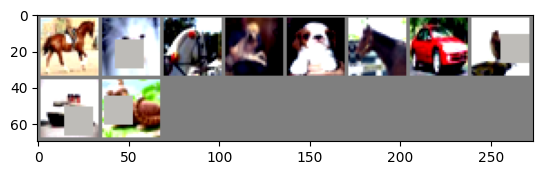

In [17]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

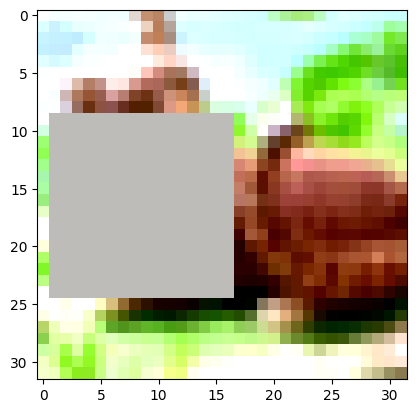

In [18]:
image = images[9]
imshow(image)

In [19]:
image = image.unsqueeze(0)
image = image.to(device)

## Loss and Accuracy curves

Text(0.5, 1.0, 'Test Accuracy')

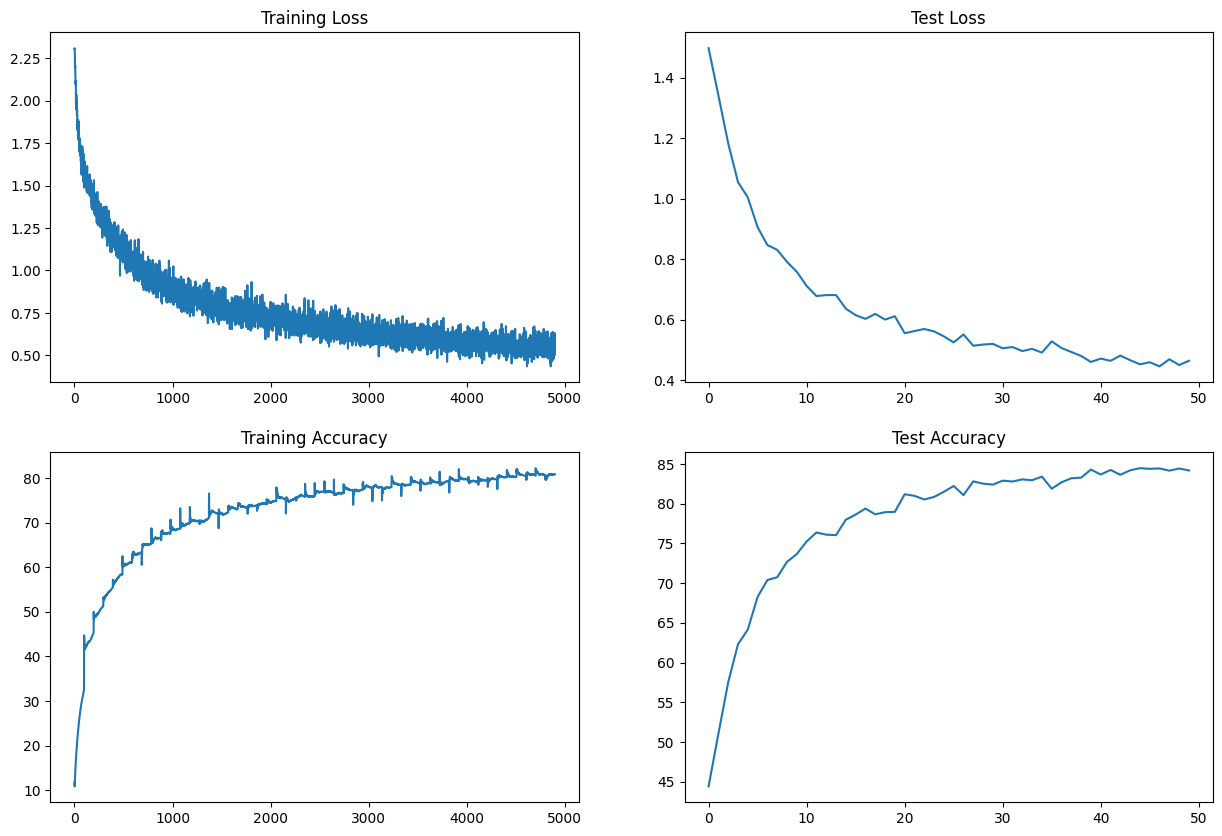

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
t=[t.cpu().item() for t in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")